In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate


In [4]:
conn = psycopg2.connect(database="keep_data", user="postgres", password="postgres", host="localhost", port="5432")
cur = conn.cursor()
df = psql.read_sql("Select * from markets_data", conn)
del df['time']
df.tail()


,open_b,close_b,high_b,low_b,vol_b,vol_conv_b,open,close,high,low,vol,vol_conv,average,cnt
100,0.002009,0.002106,0.002282,0.002002,80966.12,168.941963,0.784762,0.790339,0.853362,0.777077,1.106803e+06,8.861140e+05,0.800607,433
101,0.002104,0.002287,0.002541,0.002099,93551.66,210.427414,0.790217,0.910321,0.976179,0.788596,1.268048e+06,1.103147e+06,0.869957,597
102,0.002287,0.002200,0.002657,0.002200,62131.38,149.765756,0.909414,0.972085,1.012274,0.906893,1.039094e+06,1.004776e+06,0.966973,403
103,0.002200,0.002201,0.002426,0.002198,51683.99,119.167755,0.971193,0.977093,0.992536,0.934342,9.242518e+05,8.918199e+05,0.964910,313
104,0.002199,0.002182,0.002346,0.002021,87340.87,190.345875,0.978701,0.919141,0.990962,0.891322,1.879667e+06,1.810053e+06,0.962965,551


In [5]:
history_points = 10
data = df
data = data[::-1]
data = data.reset_index()
data = data.drop('index', axis=1)
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)
ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:,1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
next_day_open_values = np.array([data.loc[:,"close_b"][i + history_points].copy() for i in range(len(data) - history_points)])
next_day_open_values_save = next_day_open_values.copy()
next_day_open_values = np.expand_dims(next_day_open_values, -1)
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)

assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]

ohlcv_histories = ohlcv_histories_normalised
next_day_open_values = next_day_open_values_normalised
unscaled_y = next_day_open_values
y_scaler = y_normaliser

In [6]:
test_split = 0.8
n = int(ohlcv_histories.shape[0] * test_split)
ohlcv_train = ohlcv_histories[:n]
 # add technical indicator
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
 # add technical indicator
y_test = next_day_open_values[n:]

unscaled_y_test = next_day_open_values_save[n:]
print(ohlcv_train.shape)


(76, 10, 14)


In [7]:
# Build Model (RNN)
lstm_input = Input(shape=(history_points, 14), name='lstm_input')

x = LSTM(200, name='lstm_0')(lstm_input)
x = Dropout(0.7, name='lstm_dropout_0')(x)

# the second branch opreates on the second input
lstm_branch = Model(inputs=lstm_input, outputs=x)

z = Dense(256, activation="sigmoid", name='dense_pooling')(lstm_branch.output)
z = Dense(1, activation="linear", name='dense_out')(z)

# this model will accept the inputs of the two branches and then output a single value
model = Model(inputs=lstm_branch.input, outputs=z)

model.summary()
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 10, 14)]          0         
_________________________________________________________________
lstm_0 (LSTM)                (None, 200)               172000    
_________________________________________________________________
lstm_dropout_0 (Dropout)     (None, 200)               0         
_________________________________________________________________
dense_pooling (Dense)        (None, 256)               51456     
_________________________________________________________________
dense_out (Dense)            (None, 1)                 257       
Total params: 223,713
Trainable params: 223,713
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train Model
num_epochs = 300
batch_size = 64
history = model.fit(x=ohlcv_train, y=y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, validation_split=0.1)

Epoch 1/300
2/2 [==============================] - 1s 302ms/step - loss: 0.1567 - val_loss: 0.0599
Epoch 2/300
2/2 [==============================] - 0s 24ms/step - loss: 0.0426 - val_loss: 0.0097
Epoch 3/300
2/2 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 4/300
2/2 [==============================] - 0s 21ms/step - loss: 0.0215 - val_loss: 0.0084
Epoch 5/300
2/2 [==============================] - 0s 24ms/step - loss: 0.0268 - val_loss: 0.0056
Epoch 6/300
2/2 [==============================] - 0s 18ms/step - loss: 0.0158 - val_loss: 0.0038
Epoch 7/300
2/2 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 8/300
2/2 [==============================] - 0s 1

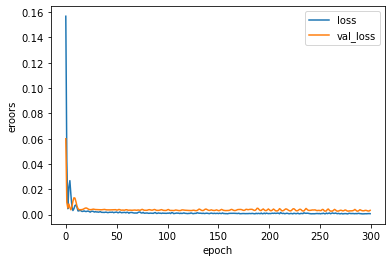

In [9]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('eroors')
plt.legend()
plt.show()

1/1 [==============================] - 0s 2ms/step - loss: 0.0595
0.0594969280064106
0.13215202584018762


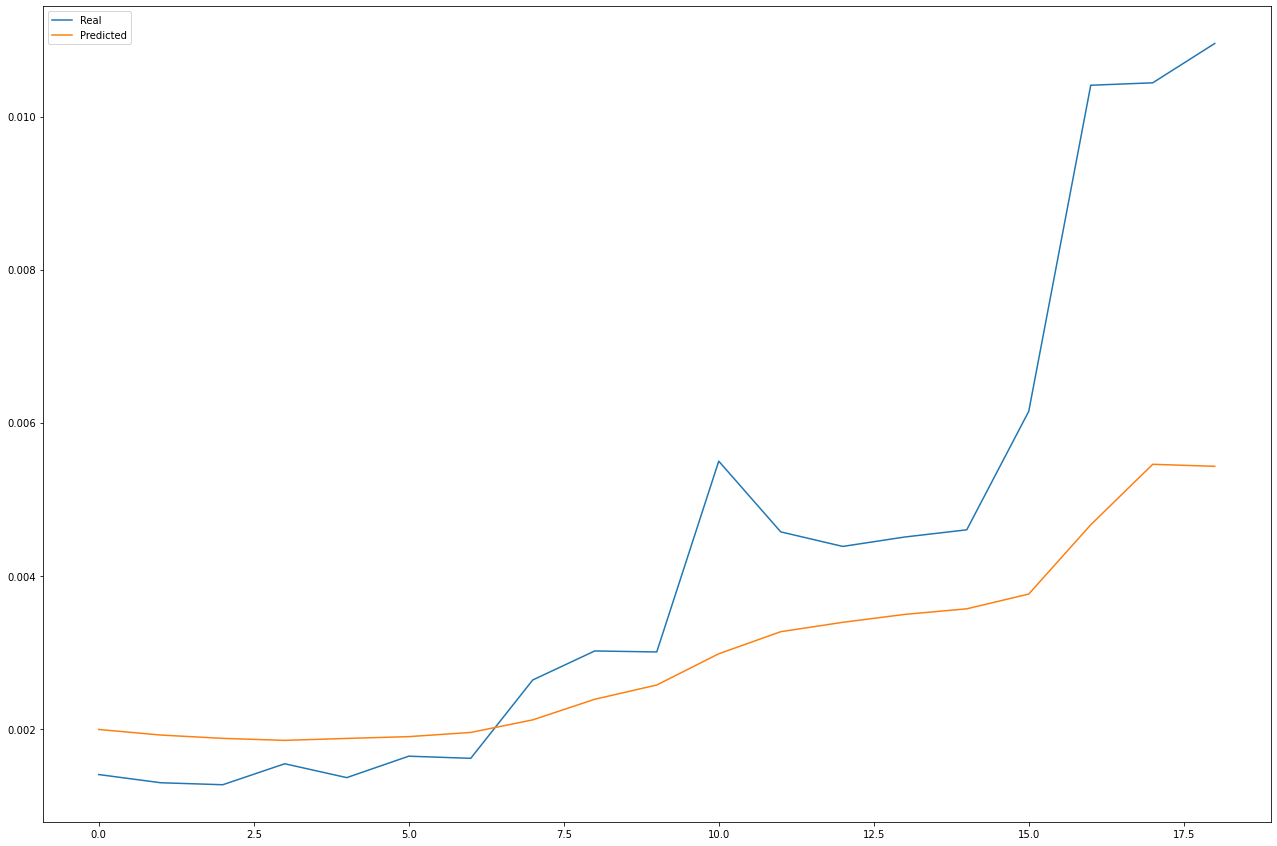

In [10]:
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_scaler.inverse_transform(y_predicted)
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

plt.gcf().set_size_inches(22, 15, forward=True)
start = 0
end = -1
real = plt.plot(unscaled_y_test, label='real')
pred = plt.plot(y_test_predicted, label='predicted')
plt.legend(['Real', 'Predicted'])
plt.show()



In [435]:
model.save("models\keep_predit_lstm.h5")